In [10]:
# compare_model.py

"""
Perbandingan performa antara model hybrid CEEMDAN + Wavelet + LSTM dengan model LSTM standar.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [ ]:


# Unduh data saham AMRT.JK
symbol = 'AMRT.JK'
df = yf.download(symbol, start='2021-01-01', end='2025-05-31')
df = df[['Close']].dropna()
df.index.name = 'Date'

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Dataset sequence
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



[*********************100%***********************]  1 of 1 completed


c:\Users\sandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

=== LSTM Biasa ===
R2    : 0.8990
RMSE  : 141.8844
MAE   : 114.1944


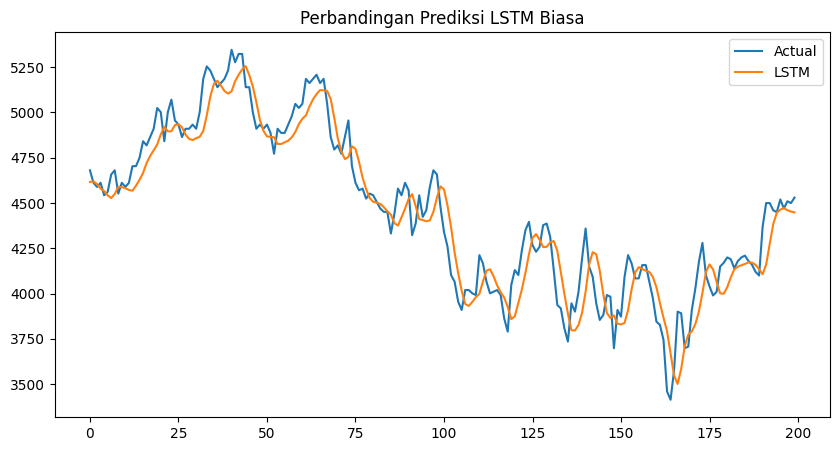


=== Hasil Prediksi 30 Hari ke Depan ===
            Forecasted Close
2025-05-29       4455.672852
2025-05-30       4443.299316
2025-06-02       4426.305664
2025-06-03       4408.476074
2025-06-04       4391.398926
2025-06-05       4375.598633
2025-06-06       4361.110840
2025-06-09       4347.750000
2025-06-10       4335.250000
2025-06-11       4323.331055
2025-06-12       4311.738281
2025-06-13       4300.261230
2025-06-16       4288.747559
2025-06-17       4277.102539
2025-06-18       4265.282715
2025-06-19       4253.291992
2025-06-20       4241.167480
2025-06-23       4228.969727
2025-06-24       4216.768066
2025-06-25       4204.634766
2025-06-26       4192.636230
2025-06-27       4180.827148
2025-06-30       4169.248535
2025-07-01       4157.927734
2025-07-02       4146.875977
2025-07-03       4136.094727
2025-07-04       4125.575684
2025-07-07       4115.302246
2025-07-08       4105.255371
2025-07-09       4095.413086


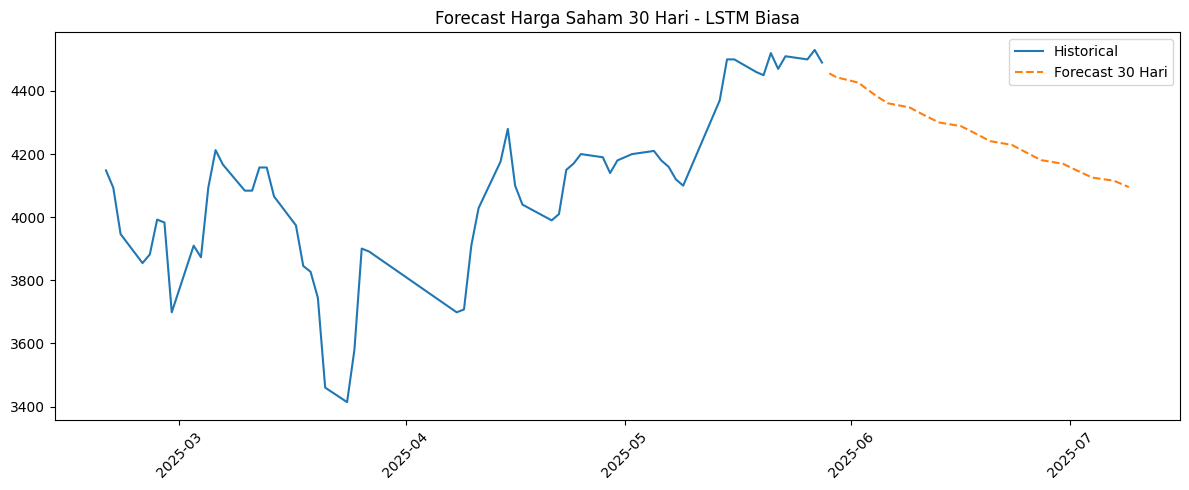

In [12]:

# Model LSTM Biasa
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=0)

# Predict
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\n=== LSTM Biasa ===")
print(f"R2    : {r2:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAE   : {mae:.4f}")

# Plot prediksi
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='LSTM')
plt.legend()
plt.title('Perbandingan Prediksi LSTM Biasa')
plt.show()

# Forecast 30 hari
last_sequence = data_scaled[-time_step:]
future_predictions = []

for _ in range(30):
    input_seq = last_sequence.reshape(1, time_step, 1)
    next_pred = model.predict(input_seq, verbose=0)[0][0]
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], [[next_pred]], axis=0)

future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_df = pd.DataFrame(future_predictions_inv, index=dates, columns=['Forecasted Close'])

print("\n=== Hasil Prediksi 30 Hari ke Depan ===")
print(forecast_df)

# Plot forecast 
plt.figure(figsize=(12, 5))
plt.plot(df.index[-60:], df['Close'].values[-60:], label='Historical')
plt.plot(forecast_df.index, forecast_df['Forecasted Close'], label='Forecast 30 Hari', linestyle='--')
plt.legend()
plt.title('Forecast Harga Saham 30 Hari - LSTM Biasa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
import openpyxl
forecast_df.to_excel("forecast_lstm_biasa.xlsx")
